In [754]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib as plt
import warnings
from pylab import rcParams
from sklearn.metrics import r2_score as r2
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt

warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [755]:
data = pd.read_csv(r'C:\Users\user\Desktop\Kurs_project_task\train.csv')

In [756]:
train, valid = train_test_split(data, test_size=0.2, random_state=42)

In [757]:
data.shape

(10000, 20)

In [758]:
train.shape

(8000, 20)

In [759]:
valid.shape

(2000, 20)

In [760]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 9254 to 7270
Data columns (total 20 columns):
Id               8000 non-null int64
DistrictId       8000 non-null int64
Rooms            8000 non-null float64
Square           8000 non-null float64
LifeSquare       6299 non-null float64
KitchenSquare    8000 non-null float64
Floor            8000 non-null int64
HouseFloor       8000 non-null float64
HouseYear        8000 non-null int64
Ecology_1        8000 non-null float64
Ecology_2        8000 non-null object
Ecology_3        8000 non-null object
Social_1         8000 non-null int64
Social_2         8000 non-null int64
Social_3         8000 non-null int64
Healthcare_1     4148 non-null float64
Helthcare_2      8000 non-null int64
Shops_1          8000 non-null int64
Shops_2          8000 non-null object
Price            8000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.3+ MB


In [769]:
train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,8000.000000,8000.000000,8000.000000,8000.000000,6299.000000,8000.00000,8000.000000,8000.000000,8.000000e+03,8000.000000,8000.000000,8000.000000,8000.000000,4148.00000,8000.000000,8000.000000,8000.000000
mean,8365.521625,50.493625,1.889125,56.267255,37.325501,6.37875,8.492375,12.623250,4.491580e+03,0.117770,24.729125,5358.405125,8.006500,1136.08703,1.313375,4.246375,214094.178589
std,4865.821409,43.691588,0.839297,20.381827,95.733053,31.84321,5.221240,6.812185,2.241661e+05,0.118239,17.609415,4016.879776,23.720008,1024.34165,1.489362,4.806018,92671.160116
min,0.000000,0.000000,0.000000,2.377248,0.370619,0.00000,1.000000,0.000000,1.912000e+03,0.000000,0.000000,168.000000,0.000000,0.00000,0.000000,0.000000,59174.778028
25%,4154.750000,20.000000,1.000000,41.745094,22.797476,1.00000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,325.00000,0.000000,1.000000,153996.751273
50%,8369.500000,36.000000,2.000000,52.549663,32.806379,6.00000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.00000,1.000000,3.000000,192152.769521
75%,12555.500000,75.000000,2.000000,65.931541,45.048935,9.00000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1548.00000,2.000000,6.000000,249135.462171
max,16796.000000,209.000000,19.000000,604.705972,7480.592129,2014.00000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.00000,6.000000,23.000000,627525.072788


In [781]:
import sys
!{sys.executable} -m pip install pandas-profiling

In [764]:
import pandas_profiling
pandas_profiling.ProfileReport(train)

In [728]:
mean_year = np.round(train.loc[train['HouseYear'] <= 2020, 'HouseYear'].mean())
mean_year

1985.0

In [729]:
def clean_year(df, mean_year):
    df.loc[df['HouseYear'] > 2020, 'HouseYear'] = mean_year

In [730]:
def clean_objects(df):
    object_map = {
        "A": 0, "B": 1 
    }
    df["Shops_2"] = df["Shops_2"].map(object_map)
    df["Ecology_2"] = df["Ecology_2"].map(object_map)
    df["Ecology_3"] = df["Ecology_3"].map(object_map)

In [731]:
def clean_life_square(df):
    df.loc[(df['LifeSquare'] < 5) | (df['LifeSquare'].isnull()), 'LifeSquare'] = df['Square']*0.85

In [732]:
def clean_housefloor(df):
    df.loc[(df['HouseFloor'] == 0, 'HouseFloor')] = 1

In [733]:
def clean_kitchen(df):
    df.loc[(df['KitchenSquare'] < 5) | (df['KitchenSquare'] > 25), 'KitchenSquare'] = df['KitchenSquare'].mean()

In [734]:
def prepare_data(df, mean_year=mean_year):
    clean_year(df, mean_year)
    clean_life_square(df)
    clean_objects(df)
    clean_kitchen(df)
    clean_housefloor(df)
    return (df)

In [752]:
prepare_data(train)
prepare_data(valid)
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9254,12473,58,1.0,65.271225,62.798045,6.37875,3,1.0,1977.0,0.437885,NaN,NaN,23,5735,3,1084.0,0,5,NaN,210849.693542
1561,14050,146,2.0,45.091598,43.816601,6.37875,5,18.0,2017.0,0.236108,NaN,NaN,16,3893,27,NaN,3,10,NaN,201549.998077
1670,3779,5,1.0,34.463114,20.561823,5.00000,3,5.0,1960.0,0.150818,NaN,NaN,16,3433,4,2643.0,4,5,NaN,158433.168775
6087,3762,90,3.0,61.931107,46.126389,5.00000,4,5.0,1966.0,0.265089,NaN,NaN,37,5288,0,1937.0,3,2,NaN,220194.818430
6669,358,1,1.0,42.670840,36.270214,6.37875,8,17.0,1977.0,0.007122,NaN,NaN,1,264,0,NaN,0,1,NaN,125834.270291


In [736]:
feats = ['DistrictId', 'Ecology_1', 'Social_3', 'Square', 'LifeSquare', 
         'Rooms', 'HouseYear', 'HouseFloor', 'KitchenSquare']

In [737]:
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42,criterion='mse')

In [738]:
model.fit(train.loc[:, feats], train['Price'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [739]:
pred_train = model.predict(train.loc[:, feats])

In [740]:
r2(train['Price'], pred_train)

0.864962832667556

In [741]:
pred_valid = model.predict(valid.loc[:, feats])

In [742]:
r2(valid['Price'], pred_valid)

0.7063988911665607

In [743]:
max_depth_grid = np.arange(2, 14)

accuracy_on_valid = []
accuracy_on_train = []

for i, value in enumerate (max_depth_grid):
    model = RandomForestRegressor(n_estimators=100, max_depth=value, random_state=42,criterion='mse')
    
    model.fit(train.loc[:, feats], train['Price'])
    pred_train = model.predict(train.loc[:, feats])
    acc_train = r2(train['Price'], pred_train)
    pred_valid = model.predict(valid.loc[:, feats])
    acc_valid = r2(valid['Price'], pred_valid)
#     if i % 4 == 2:
#         print('K = {}'.format(value))
#         print('\tacc_valid = {}'.format(acc_valid))
#         print('\tacc_train = {}\n'.format(acc_train))
    
    accuracy_on_valid.append(acc_valid)
    accuracy_on_train.append(acc_train)
    
     

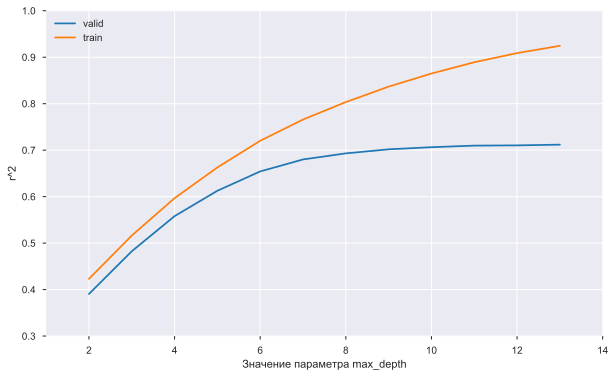

In [744]:
plt.rcParams['figure.figsize'] = 10, 6

plt.plot(max_depth_grid, accuracy_on_valid, label="valid")
plt.plot(max_depth_grid, accuracy_on_train, label="train")

plt.xlabel('Значение параметра max_depth')
plt.ylabel('r^2')

plt.legend()
plt.grid(1)
plt.axis([1.0, 14.0, 0.3, 1.0])

plt.show()

prediction RendomForestRegressor

In [745]:
test = pd.read_csv(r'C:\Users\user\Desktop\Kurs_project_task\test.csv')

In [746]:
test.shape

(5000, 19)

In [748]:
prepare_data(test)
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0000,6,14.0,1972.0,0.310199,NaN,NaN,11,2748,1,NaN,0,0,NaN
1,15856,74,2.0,69.263183,58.873706,5.9768,6,1.0,1977.0,0.075779,NaN,NaN,6,1437,3,NaN,0,2,NaN
2,5480,190,1.0,13.597819,15.948246,12.0000,2,5.0,1909.0,0.000000,NaN,NaN,30,7538,87,4702.0,5,5,NaN
3,15664,47,2.0,73.046609,51.940842,9.0000,22,22.0,2007.0,0.101872,NaN,NaN,23,4583,3,NaN,3,3,NaN
4,14275,27,1.0,47.527111,43.387569,5.9768,17,17.0,2017.0,0.072158,NaN,NaN,2,629,1,NaN,0,0,NaN


In [749]:
test['Price'] = model.predict(test.loc[:, feats])

In [782]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,725,58,2.0,49.882643,33.432782,6.0000,6,14.0,1972.0,0.310199,NaN,NaN,11,2748,1,NaN,0,0,NaN,160221.752084
1,15856,74,2.0,69.263183,58.873706,5.9768,6,1.0,1977.0,0.075779,NaN,NaN,6,1437,3,NaN,0,2,NaN,217615.094151
2,5480,190,1.0,13.597819,15.948246,12.0000,2,5.0,1909.0,0.000000,NaN,NaN,30,7538,87,4702.0,5,5,NaN,228969.903706
3,15664,47,2.0,73.046609,51.940842,9.0000,22,22.0,2007.0,0.101872,NaN,NaN,23,4583,3,NaN,3,3,NaN,305235.820683
4,14275,27,1.0,47.527111,43.387569,5.9768,17,17.0,2017.0,0.072158,NaN,NaN,2,629,1,NaN,0,0,NaN,142344.637915


In [786]:
#test.info()

In [784]:
#pandas_profiling.ProfileReport(test)

In [5]:
test.loc[:, ['Id', 'Price']].to_csv('DLetyuk_predictions.csv', index=False)